Prerequisites
=============

* astropy
* Pickle files containing the lightcurves from generate_lightcurves.ipynb

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import cPickle

from astropy.stats import LombScargle

plt.style.use(['ggplot', 'ggplot_mod.mplstyle'])

RR Lyrae
========

In [2]:
# Load from the pickle file
f = open("rrlyrae_lightcurves.pkl")
rrlyrae_lc, rrlyrae_truth = cPickle.load(f)
f.close()

`rrlyrae_lc` is a dictionary, and each entry is a single object identified by an object id.

We can pick the first object with:

In [3]:
single_rrlyrae = rrlyrae_lc[rrlyrae_lc.keys()[1]]

Inside that light curve is a dictionary of different photometric bands:

In [4]:
print(single_rrlyrae.keys())

['i', 'r', 'z', 'g']


Each of which contains the date, magnitude, and magnitude error of the observation:

In [5]:
print(single_rrlyrae['r'].keys())

['mjd', 'mag', 'error']


**Important note**: The `mag` column is the exact value of the model light curve *with no photometric error*. If you want to obtain as-observed magnitudes, you will need to add scatter according to the error column.

In [6]:
for band, band_data in single_rrlyrae.items():
    band_data['mag'] +=  np.random.normal(scale=band_data['error'])

Let's plot a single light curve, in all bands:

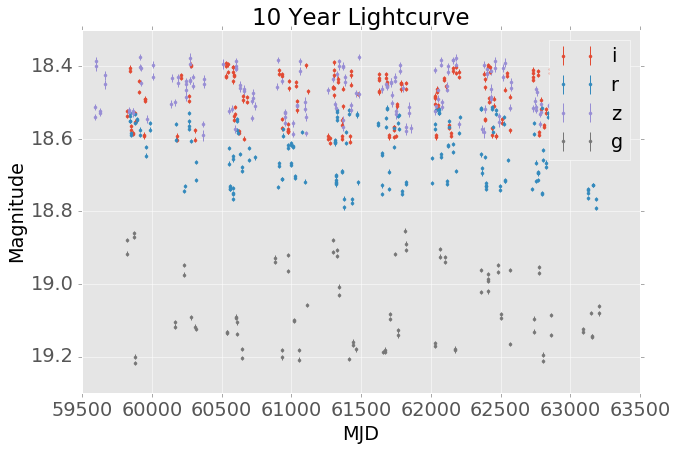

In [7]:
for band, band_data in single_rrlyrae.items():
    plt.errorbar(band_data['mjd'], band_data['mag'], band_data['error'], fmt = '.', capsize=0, label=band)
    
plt.xlabel("MJD")
plt.ylabel("Magnitude")
plt.legend()
plt.gca().invert_yaxis()
plt.title("10 Year Lightcurve")

This is a full 10 years of data. You can see each observing season grouped together.

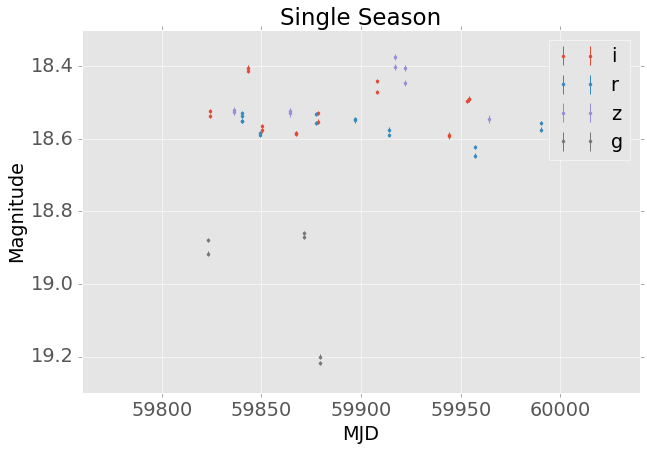

In [8]:
for band, band_data in single_rrlyrae.items():
    plt.errorbar(band_data['mjd'], band_data['mag'], band_data['error'], fmt = '.', capsize=0, label=band)

    
plt.xlabel("MJD")
plt.ylabel("Magnitude")
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(59900 - 140, 59900 + 140)
plt.title("Single Season")

Finding the RR Lyrae Period
---------------------------

To turn this into something more intuitive, we need to fold the light curve, which means we need to know the period. We can create a simple Lomb-Scargle periodogram to give us a rough estimate of this period.

RR Lyrae Period: 0.297870 days


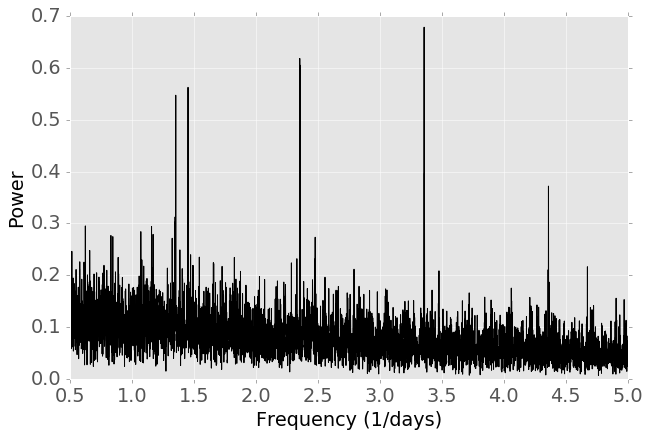

In [14]:
band_data = single_rrlyrae['r']
ls = LombScargle(band_data['mjd'], band_data['mag'], band_data['error'], nterms=5)
frequency = np.linspace(1./2, 1./0.2, 5000) # 1/days
power = ls.power(frequency)
#frequency, power = ls.autopower()

plt.plot(frequency, power, 'k-')
plt.xlabel("Frequency (1/days)")
plt.ylabel("Power")

best_frequency = frequency[np.argmax(power)]
peak_period = 1./(best_frequency)

print("RR Lyrae Period: {:f} days".format(peak_period))

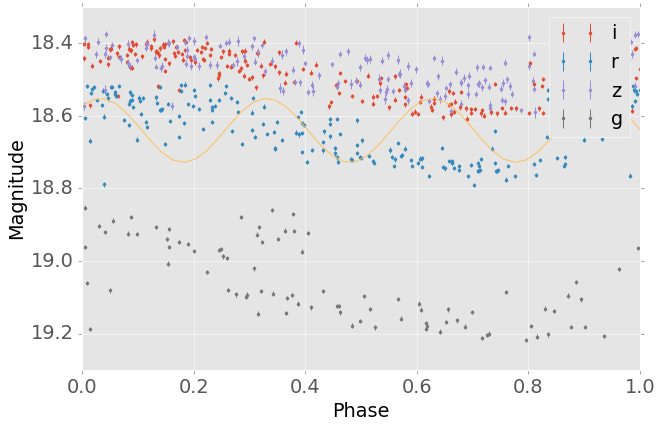

In [12]:
p_fit = np.linspace(0, 1)
y_fit = ls.model(p_fit, best_frequency)

for band, band_data in single_rrlyrae.items():
    phase = (band_data['mjd']/peak_period) % 1
    plt.errorbar(phase, band_data['mag'], band_data['error'], fmt = '.', capsize=0, label=band)

plt.plot(p_fit, y_fit)
    
plt.ylabel("Magnitude")
plt.xlabel("Phase")
plt.legend()
plt.gca().invert_yaxis()

More you can do: fit periods for all objects; try multi-band periodograms with the [gatspy](http://www.astroml.org/gatspy/) package.

Debugging
=========

Below here are some snippets that were useful in debugging some of this code. This can be safely ignored by most users.

The first part extracts the true period from the truth dictionary. This requires the `sims_sed_library` package to be installed, so it is not available with just the pickle files.

In [10]:
import eups
import os
import ast

base_dir = eups.productDir("sims_sed_library")

single_rrlyrae_truth = ast.literal_eval(rrlyrae_truth[rrlyrae_lc.keys()[1]])

truth_filename = os.path.join(base_dir, single_rrlyrae_truth['pars']['filename'])
f = open(truth_filename)
with open(truth_filename) as f:
    for n, line in enumerate(f):
        m = re.match("# Period .* (\d*\.\d*)", line)
        if m:
            period = float(m.group(1))
            print("Period: {:f}".format(period))
        if n > 5:
            break

Period: 0.738330
